In [1]:
%load_ext autoreload
%autoreload 2
import sys
sys.path.append('../..')
#sys.path.append( '/home/cactuskid13/miniconda3/pkgs/')
print(sys.path)

['/scratch/dmoi/projects/HogProf/pyprofiler/notebooks', '/scratch/dmoi/condaenvs/ML2/lib/python39.zip', '/scratch/dmoi/condaenvs/ML2/lib/python3.9', '/scratch/dmoi/condaenvs/ML2/lib/python3.9/lib-dynload', '', '/scratch/dmoi/condaenvs/ML2/lib/python3.9/site-packages', '/scratch/dmoi/condaenvs/ML2/lib/python3.9/site-packages/IPython/extensions', '/users/dmoi/.ipython', '../..']


In [2]:
#idea! try graph net on the species tree with the same approach as covid
#predict connection nodes and score on the human result


#hilbert space analysis?

#try blurring approach with species tree connectivity mat



In [3]:
#using the profiler. It's easy!
#lets import the profiler, configuration file and some tools for GO analysis to look at our returned results
from pyprofiler.utils import config_utils
import pyprofiler.utils.goatools_utils as goa
import pyprofiler.utils.hashutils as hashutils
import seaborn as sns

import pyprofiler.profiler as profiler
import pandas as pd
import numpy as np

{'dir': {'datadir': '/scratch/dmoi/datasets/birds/', 'omadir': '/scratch/dmoi/datasets/birds/'}, 'orthoxmltar': '', 'email': 'dmoi@unil.ch'}


In [4]:
#lets load a compiled db containing the OMA root HOGs into a profiler oject 
p = profiler.Profiler(lshforestpath = '/scratch/dmoi/datasets/all/newlshforest.pkl' , hashes_h5='/scratch/dmoi/datasets/birds/all/hashes.h5' , mat_path= None, oma = '/scratch/dmoi/datasets/OMA/apr2021/OmaServer.h5', tar= None , nsamples = 256 , mastertree = '/scratch/dmoi/datasets/birds/all_master_tree.pkl')

loading lsh
indexing lsh


/scratch/dmoi/condaenvs/ML2/lib/python3.9/site-packages/tables/leaf.py:367: PerformanceWarning: The Leaf ``/Protein/_i_Entries/OmaHOG/sorted`` is exceeding the maximum recommended rowsize (104857600 bytes);
be ready to see PyTables asking for *lots* of memory and possibly slow
I/O.  You may want to reduce the rowsize by trimming the value of
dimensions that are orthogonal (and preferably close) to the *main*
dimension of this leave.  Alternatively, in case you have specified a
very small/large chunksize, you may want to increase/decrease it.
  warnings.warn("""\


3508
DONE


In [5]:
def grabHog(ID, verbose = True):
    try:
        entry = p.db_obj.entry_by_entry_nr(p.db_obj.id_resolver.resolve(ID))
        return entry[4].decode() , entry
    except:
        return np.nan,np.nan
#map to OMA HOGs

In [6]:
#load humap data
humap = '/scratch/dmoi/datasets/humap_PPI/humap2_ppis_ACC_20200821.pairsWprob'
df = pd.read_table(humap, header = None)
print(df)

                  0                1             2
0            P46926           Q8TDQ7  1.000000e+00
1            P43631           Q14954  1.000000e+00
2            P43631           Q14953  1.000000e+00
3            P43631           P43629  1.000000e+00
4         100287045           Q86YD7  1.000000e+00
...             ...              ...           ...
17526306     Q9H6Z4           Q7L1Q6  3.000000e-14
17526307     Q9Y265           P54578  3.000000e-14
17526308     P16152           P04406  3.000000e-14
17526309     Q96AE4           P78417  3.000000e-14
17526310     P20042  ENSG00000180574  3.000000e-14

[17526311 rows x 3 columns]


In [7]:
#filter to 90%proba
df = df[df[2] > .75 ]
print(len(df))
mapper = set( list(df[1]) + list(df[0]) )
mapper = { protid: grabHog(protid) for protid in mapper }
df['hog1'] = df[1].map(mapper)
df['hog2'] = df[0].map(mapper)
print(df)

8981


/scratch/dmoi/condaenvs/ML2/lib/python3.9/site-packages/tables/leaf.py:367: PerformanceWarning: The Leaf ``/_i_XRef/XRefId/sorted`` is exceeding the maximum recommended rowsize (104857600 bytes);
be ready to see PyTables asking for *lots* of memory and possibly slow
I/O.  You may want to reduce the rowsize by trimming the value of
dimensions that are orthogonal (and preferably close) to the *main*
dimension of this leave.  Alternatively, in case you have specified a
very small/large chunksize, you may want to increase/decrease it.
  warnings.warn("""\


              0       1         2  \
0        P46926  Q8TDQ7  1.000000   
1        P43631  Q14954  1.000000   
2        P43631  Q14953  1.000000   
3        P43631  P43629  1.000000   
4     100287045  Q86YD7  1.000000   
...         ...     ...       ...   
8976     P12524  Q6P597  0.750250   
8977     P28074  Q99460  0.750249   
8978     P78537  Q96GS4  0.750214   
8979     O14972  O60826  0.750171   
8980     Q9Y244  P20618  0.750156   

                                                   hog1  \
0     (HOG:A0786418.3b.3a.6b.7b.3a.5a.1a, [10509897,...   
1     (HOG:A0495961.1b.4c.1b, [10480506, 4099522525,...   
2     (HOG:A0495961.1b.4c.1a, [10480505, 4099522183,...   
3     (HOG:A0495961.1a.1b, [10480515, 4099525487, 44...   
4     (HOG:A0498062.5c, [10445481, 4087452873, 465, ...   
...                                                 ...   
8976  (HOG:A0552037.1b, [10478826, 4099019790, 505, ...   
8977  (HOG:A0563496.5a.4a.3b.7a.8b, [10501895, 41083...   
8978  (HOG:A0501712.1a, 

In [8]:
df['hogid_1'] = df['hog1'].map(lambda x:x[0])
df['hogid_2'] = df['hog2'].map(lambda x:x[0])

df = df.dropna()
print(len(df))

8576


In [9]:
print(df.iloc[0].hog1)

df['fam1'] , df['OMA_ID1']  =  zip(*df['hog1'].map( lambda x : (x[1][0] , x[1][10].decode() ) ))
df['fam2'] , df['OMA_ID2']  =  zip(*df['hog2'].map( lambda x : (x[1][0] , x[1][10].decode() ) ))

print(df)

('HOG:A0786418.3b.3a.6b.7b.3a.5a.1a', (10509897, 4111452217, 277, 1038133, b'HOG:A0786418.3b.3a.6b.7b.3a.5a.1a', b'4', 44703081, 44722207, -1, 10509897, b'GNPI2_HUMAN', 12344866547, 832, b'f52389e1e8ba309b6343fde3f669313a', 555078997, 104, b'', -1, -1))
           0       1         2  \
0     P46926  Q8TDQ7  1.000000   
1     P43631  Q14954  1.000000   
2     P43631  Q14953  1.000000   
3     P43631  P43629  1.000000   
6     H3BUK9  339010  1.000000   
...      ...     ...       ...   
8976  P12524  Q6P597  0.750250   
8977  P28074  Q99460  0.750249   
8978  P78537  Q96GS4  0.750214   
8979  O14972  O60826  0.750171   
8980  Q9Y244  P20618  0.750156   

                                                   hog1  \
0     (HOG:A0786418.3b.3a.6b.7b.3a.5a.1a, [10509897,...   
1     (HOG:A0495961.1b.4c.1b, [10480506, 4099522525,...   
2     (HOG:A0495961.1b.4c.1a, [10480505, 4099522183,...   
3     (HOG:A0495961.1a.1b, [10480515, 4099525487, 44...   
6     (, [339010, 96937507, 160, 0, b'', b

3508
nodes


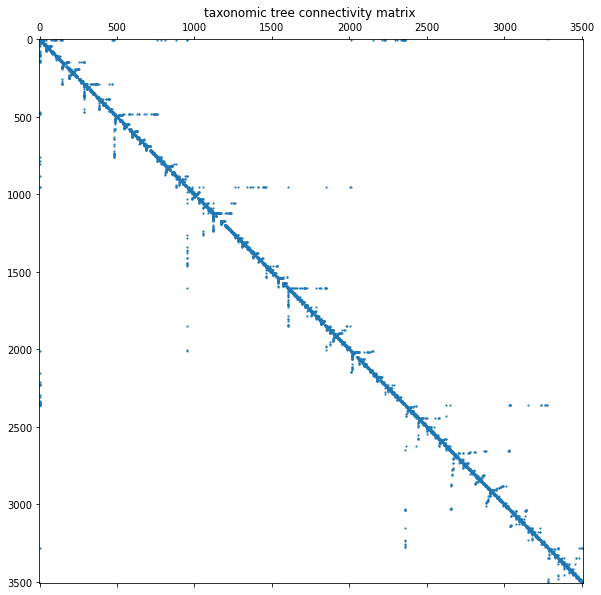

In [10]:
#save with mapped ids
import scipy
import dendropy
from matplotlib import pyplot as plt
species_tree = p.tree
with open('species_tree.nwk', 'w')as treeout:
    treeout.write( species_tree.write())

tree = dendropy.Tree.get( path='species_tree.nwk', schema='newick')


for i,n in enumerate(tree.nodes()):
    n.matrow = i
    n.symbols = None
    n.scores = None
    n.event = None
    n.char = None

matsize = len(tree.nodes())
print(matsize)
print('nodes')
#blur w connectivity mat
blurfactor =  .25
connectmat = scipy.sparse.lil_matrix((len(tree.nodes()), len(tree.nodes() ) ) )
index = np.array([ [n.matrow, c.matrow ] for n in tree.nodes() for c in n.child_nodes()])


connectmat[index[:,0],index[:,1]] = 1
connectmat[index[:,1],index[:,0]] = 1
sumlengths = connectmat.sum(axis=1)
#diag= scipy.sparse.diags(1,[0])
#connectmat += diag

connectmat = scipy.sparse.coo_matrix(connectmat)
plt.figure( figsize=(10,10))
plt.title( 'taxonomic tree connectivity matrix ' )
plt.spy(connectmat, markersize= 1)
plt.show()



In [11]:
#select a node to generate a small network of known positives
#tsnare
start_prot = 'Q86X76'

neighbors_iter=4
#get neighborhood
#make subdf of the hood



print(len(df))
df = df[~df.fam1.isnull()  & ~df.fam2.isnull()]

df['fam1']= df['fam1'].astype(int)
df['fam2']= df['fam2'].astype(int)

grablist = set([start_prot])

#change this to a less stringent dataset for getting the subnet...
#this could be masking good interactions

for i in range(neighbors_iter):
    sub =  df[df[0].isin(grablist) | df[1].isin(grablist)  ]
    print(i)
    [grablist.add( p )  for p in list(sub[0].unique())]
    [grablist.add( p )  for p in list(sub[1].unique())]
#grab subdf close to the initial query


print(sub)
print(len(sub))
print( len( grablist ) )

8576
0
1
2
3
           0       1         2  \
152   Q8N142  P30520  1.000000   
1967  P00441  P30405  0.999999   
2279  P09960  P18206  0.999992   
2305  P17174  P30405  0.999991   
2396  P40925  P30405  0.999987   
...      ...     ...       ...   
8897  P13929  P0DN79  0.760149   
8908  P13929  P51857  0.759222   
8921  C9JRZ8  Q9BYZ2  0.756873   
8948  P30566  Q9BYZ2  0.754028   
8963  Q6NVY1  P48735  0.752040   

                                                   hog1  \
152   (HOG:A0779881.1b.9a.10b.8a.11c.1b, [10489957, ...   
1967  (HOG:A0554849.6ab.62h.43g, [10436372, 40841280...   
2279  (HOG:A0555159.2b.2c.6b.3b, [10436196, 40840054...   
2305  (HOG:A0554849.6ab.62h.43g, [10436372, 40841280...   
2396  (HOG:A0554849.6ab.62h.43g, [10436372, 40841280...   
...                                                 ...   
8897  (HOG:A0554841.6c.18a.7a.8a.5b, [10492519, 4104...   
8908  (HOG:A0562244.9ab.165n, [10525968, 4117904784,...   
8921  (HOG:A0570515.2g.3n.27b, [10457847, 40919

133
[[0.       0.       0.       ... 0.989698 0.       0.      ]
 [0.       0.       0.       ... 0.       0.       0.      ]
 [0.       0.       0.       ... 0.       0.       0.      ]
 ...
 [0.989698 0.       0.       ... 0.       0.       0.      ]
 [0.       0.       0.       ... 0.       0.       0.      ]
 [0.       0.       0.       ... 0.       0.       0.      ]]
243


/tmp/4105294/ipykernel_1724723/1290637315.py:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  sub['row']= sub[0].map(protindex)
/tmp/4105294/ipykernel_1724723/1290637315.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  sub['column'] = sub[1].map(protindex)


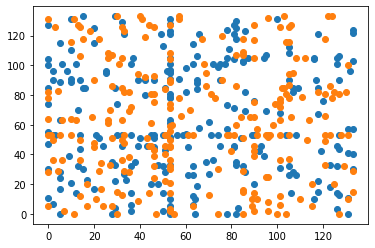

In [12]:
#define connectivity matrix
from matplotlib import pyplot as plt
connectmat = np.zeros((len(grablist), len(grablist)))
connectmat_binary = np.zeros( ( len(grablist), len(grablist)) )

protindex={ p:i for i,p in enumerate(grablist)}
print(max(protindex.values()))
sub['row']= sub[0].map(protindex)
sub['column'] = sub[1].map(protindex)

#symmetric connectivity matrix
connectmat[sub.row, sub.column] = sub[2]
connectmat+= connectmat.T
print(connectmat)
connectmat_binary[sub.row, sub.column] = sub[2]
connectmat_binary+= connectmat_binary.T


print(len(sub))
plt.scatter(sub.row, sub.column)
plt.scatter(sub.column, sub.row)
plt.show()
#this is the ground truth mat
#might not be complete but these should be considered true positives


In [ ]:
#create data for our explicit comparisons
from pyprofiler.utils import hashutils
import ete3
allhogs = set([])
[allhogs.add( h ) for h in sub.fam1.unique()]
[allhogs.add( h ) for h in sub.fam2.unique()]

explicit_profiles = p.retmat_mp_profiles( allhogs , nworkers= 40 )


[INFO/Process-1] child process calling self.run()
[INFO/Process-3] child process calling self.run()
[INFO/Process-2] child process calling self.run()
[INFO/Process-4] child process calling self.run()
[INFO/Process-5] child process calling self.run()


worker start2worker start1

worker start0worker start4worker start3

[INFO/Process-7] child process calling self.run()
[INFO/Process-6] child process calling self.run()




worker start6
worker start5



[INFO/Process-8] child process calling self.run()
[INFO/Process-9] child process calling self.run()


worker start7

[INFO/Process-10] child process calling self.run()


worker start8


[INFO/Process-11] child process calling self.run()


worker start9worker start10




[INFO/Process-12] child process calling self.run()
[INFO/Process-13] child process calling self.run()


worker start11

[INFO/Process-14] child process calling self.run()


worker start12
worker start13



[INFO/Process-15] child process calling self.run()
[INFO/Process-16] child process calling self.run()


worker start14

[INFO/Process-17] child process calling self.run()


worker start15


[INFO/Process-18] child process calling self.run()


worker start16


[INFO/Process-19] child process calling self.run()


worker start17
worker start18


[INFO/Process-20] child process calling self.run()


[INFO/Process-21] child process calling self.run()
[INFO/Process-22] child process calling self.run()


worker start20worker start19worker start21




[INFO/Process-23] child process calling self.run()
[INFO/Process-24] child process calling self.run()
[INFO/Process-25] child process calling self.run()


worker start22worker start23

[INFO/Process-26] child process calling self.run()


worker start24

worker start25


[INFO/Process-27] child process calling self.run()



worker start26

[INFO/Process-28] child process calling self.run()


[INFO/Process-29] child process calling self.run()
[INFO/Process-30] child process calling self.run()


worker start28worker start29

worker start27


[INFO/Process-31] child process calling self.run()
[INFO/Process-32] child process calling self.run()
[INFO/Process-33] child process calling self.run()


worker start30worker start31worker start32

[INFO/Process-34] child process calling self.run()





worker start33

[INFO/Process-35] child process calling self.run()


[INFO/Process-36] child process calling self.run()


worker start34

[INFO/Process-37] child process calling self.run()


worker start35
worker start36


[INFO/Process-38] child process calling self.run()



worker start37

[INFO/Process-39] child process calling self.run()



worker start38

[INFO/Process-40] child process calling self.run()



worker start39


In [ ]:
print(explicit_profiles)

In [ ]:
import ete3
taxonomy = p.tree
taxindex ={ n:i for i,n in enumerate(taxonomy.traverse())}
reverse ={ i:n for i,n in enumerate(taxonomy.traverse())}


In [ ]:
#mapfam to matrow
fam_map= { f:i for i,f in enumerate(explicit_profiles.index)}
profilemat = np.vstack(explicit_profiles.mat)


In [16]:


print(len(allhogs))
#filter out the entries in sub that don't have a profile

sub=sub[ sub.fam1.isin(fam_map) & sub.fam2.isin(fam_map)]
gold_standard = gold_standard[ gold_standard.fam1.isin(fam_map) & gold_standard.fam2.isin(fam_map)]

print(len(sub))


8122
862


In [17]:
#use all of the gold standard to train and use the subnet to quantify
import itertools

def chunks(df, n):
    for i in range(0, len(df), n):
        yield df.iloc[i:i + n]
        
def generateXYchunk(explicit_profiles, goldstandardDF,  nsamples=100, posi_percent = .5):
    #shuffle
    goldstandardDF = goldstandardDF.sample(frac=1)
    for chunkdf in chunks(goldstandardDF , int( nsamples*posi_percent)):
        #negatives drawn from the overall dataset
        X = np.hstack([ np.vstack([profilemat[fam_map[f]] for f in chunkdf.fam1]) , np.vstack([profilemat[fam_map[f]] for f in chunkdf.fam2]) ] )
        Y = [1]* X.shape[0]
        neg1 = list(goldstandardDF.sample(n = int(nsamples*(1-posi_percent))).fam1)
        neg2 = list(goldstandardDF.sample(n = int(nsamples*(1-posi_percent))).fam2)
        
        if len(neg1)>0:
            mixchunk = np.hstack([np.vstack([profilemat[fam_map[f]] for f in neg1]),np.vstack([profilemat[fam_map[f]] for f in neg2])])
            Y =np.hstack([[0]* mixchunk.shape[0] , Y])
            X= np.vstack([mixchunk,X])    
        #positive samples
        yield X, Y
    

def Testwsubnet(explicit_profiles, sub ):
    
    print(len(sub))
    
    Xposi = np.hstack([ np.vstack([profilemat[fam_map[f]] for f in sub.fam1]) , np.vstack([profilemat[fam_map[f]] for f in sub.fam2]) ] )
    print(Xposi.shape)
    pospairs = set(zip( list(sub.fam1) , list(sub.fam2)))
    
    allsubfams = set( list(sub.fam1) +list(sub.fam2) )
    
    nega = set( [(f1,f2) for f1,f2 in itertools.combinations(allsubfams,2) if (f1,f2) not in pospairs] )
    Xnega = np.vstack( [ np.hstack( [ profilemat[fam_map[f1]] , profilemat[fam_map[f2]] ]  )  for f1,f2 in nega ] )
    print(Xnega.shape)
    X = np.vstack([Xnega,Xposi])
    Y = np.hstack([[0]*Xnega.shape[0], [1]*Xposi.shape[0]])
    
    return X, Y

In [175]:

from sklearn.metrics import precision_recall_curve
import matplotlib.pyplot as plt

from sklearn.metrics import roc_curve
from sklearn.metrics import auc

def ROC_curve(y_data):

    plt.figure(figsize=(10,10))
    plt.plot([0, 1], [0, 1], 'k--')
    for l in y_data:
        print(l)
        
        y_pred_grd = y_data[l]['Ytrue']
        y_test = y_data[l]['Ypred']
        
        
        fpr, tpr, _ = roc_curve(   y_pred_grd ,y_test)
        plt.plot(fpr, tpr, label=l + 'auc'+ str(auc(fpr, tpr) ))
        plt.xlabel('False positive rate')
        plt.ylabel('True positive rate')
    
    plt.title('ROC curve')
    plt.legend(loc='best')
    plt.show()

    plt.figure(figsize=(10,10))

    for l in y_data:
        y_pred_grd = y_data[l]['Ytrue']
        y_test = y_data[l]['Ypred']
        
        precision, recall, thresholds = precision_recall_curve( y_pred_grd, y_test)
        plt.plot(precision, recall , label= l )
        plt.xlabel('Precision')
        plt.ylabel('Recall')
    
    plt.title('PR curve')
    plt.legend(loc='best')
    plt.show()

    
def ROC_curve_single(y_test, y_pred_grd):
    fpr_grd, tpr_grd, _ = roc_curve(y_test, y_pred_grd)

    plt.plot([0, 1], [0, 1], 'k--')

    fpr, tpr, _ = roc_curve(y_test, y_pred_grd)
    plt.plot(fpr, tpr, label='single')
    plt.xlabel('False positive rate')
    plt.ylabel('True positive rate')

    plt.title('ROC curve')
    plt.legend(loc='best')
    plt.show()

    precision, recall, thresholds = precision_recall_curve(  y_test , y_pred_grd)
    plt.plot(precision, recall , label='single')
    plt.xlabel('Precision')
    plt.ylabel('Recall')

    plt.title('PR curve')
    plt.legend(loc='best')
    plt.show()


In [173]:
fams = list(set( sub.fam1).union(set(sub.fam2)))

connectmat = np.zeros((len(fams), len(fams)))
connectmat_binary = np.zeros((len(fams), len(fams)))

protindex={ p:i for i,p in enumerate(fams)}

sub['famrow']= sub.fam1.map(protindex)
sub['famcolumn'] = sub.fam2.map(protindex)

#symmetric connectivity matrix
connectmat[sub.famrow, sub.famcolumn] = sub.combined_score
connectmat+= connectmat.T
print(connectmat)

connectmat_binary[sub.famrow, sub.famcolumn] = 1
np.fill_diagonal( connectmat_binary , 1 )
print(connectmat_binary)
#connectmat_binary+= connectmat_binary.T

[[   0.    0.    0. ...    0.    0.    0.]
 [   0.    0.    0. ...    0.    0. 2746.]
 [   0.    0.    0. ...    0.    0.    0.]
 ...
 [   0.    0.    0. ... 5312.    0.    0.]
 [   0.    0.    0. ...    0.    0.    0.]
 [   0. 2746.    0. ...    0.    0.    0.]]
[[1. 0. 0. ... 0. 0. 0.]
 [0. 1. 0. ... 0. 0. 1.]
 [0. 0. 1. ... 0. 0. 0.]
 ...
 [0. 0. 0. ... 1. 0. 0.]
 [0. 0. 0. ... 0. 1. 0.]
 [0. 1. 0. ... 0. 0. 1.]]


In [19]:
ydata = {}

In [25]:
Xtest, Ytest = Testwsubnet(explicit_profiles, sub )
print(Xtest.shape)
print(Ytest)

862
(862, 18690)
(6877, 18690)
(7739, 18690)
[0 0 0 ... 1 1 1]


In [140]:
from sklearn.neural_network import BernoulliRBM
#idea. clamp one profile to generate all possible interactors
#use to query lsh.

generator = generateXYchunk(explicit_profiles, gold_standard , posi_percent= .5 , nsamples = 50 )
rbm = BernoulliRBM(random_state=0, verbose=True , learning_rate=0.10, batch_size=50, n_iter= 100   )
rbm.n_components = 50

maxsamples = 3000

for i, sample in enumerate(generator):
    x,y = sample
    if i % 100 == 0: 
        print(i)
    rbm.partial_fit(x,y)
    if i - maxsamples == 0:
        break

0
100
200
300
400
500
600
700
800
900
1000
1100
1200
1300
1400
1500
1600
1700
1800
1900
2000
2100
2200
2300
2400
2500
2600
2700
2800
2900
3000


In [141]:
generator = generateXYchunk(explicit_profiles, gold_standard , posi_percent= .5 , nsamples = 50 )
maxiter = 3000
Y = []
X_rbm1 = []
for i, sample in enumerate(generator):
    x,y = sample
    if i % 100 == 0 :
        print(i)
    if i - maxiter == 0 :
        break
    X_rbm1.append(rbm.transform( x) )
    Y.append(y)

X_rbm1 = np.vstack( X_rbm1 )
Y = np.hstack(Y)


0
100
200
300
400
500
600
700
800
900
1000
1100
1200
1300
1400
1500
1600
1700
1800
1900
2000
2100
2200
2300
2400
2500
2600
2700
2800
2900
3000


In [142]:
print(X_rbm1)
print(Y)

[[1.00000000e+00 1.00000000e+00 1.00000000e+00 ... 1.00000000e+00
  2.23225415e-16 1.00000000e+00]
 [6.63936043e-41 5.64702783e-84 0.00000000e+00 ... 1.00000000e+00
  6.66883561e-47 1.00000000e+00]
 [1.00000000e+00 1.00000000e+00 1.00000000e+00 ... 1.00000000e+00
  1.00000000e+00 1.00000000e+00]
 ...
 [1.00000000e+00 1.00000000e+00 1.00000000e+00 ... 1.00000000e+00
  1.00000000e+00 1.00000000e+00]
 [1.00000000e+00 1.00000000e+00 9.33082947e-01 ... 1.00000000e+00
  1.00000000e+00 1.00000000e+00]
 [1.00000000e+00 1.00000000e+00 1.00000000e+00 ... 1.00000000e+00
  1.00000000e+00 1.00000000e+00]]
[0 0 0 ... 1 1 1]


In [143]:
from sklearn.svm import LinearSVR
regr = LinearSVR(random_state=0, tol=1e-5 , )
regr.fit(X_rbm1 , Y)

/home/cactuskid13/miniconda3/envs/pyprofiler3/lib/python3.7/site-packages/sklearn/svm/base.py:929: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)


LinearSVR(C=1.0, dual=True, epsilon=0.0, fit_intercept=True,
          intercept_scaling=1.0, loss='epsilon_insensitive', max_iter=1000,
          random_state=0, tol=1e-05, verbose=0)

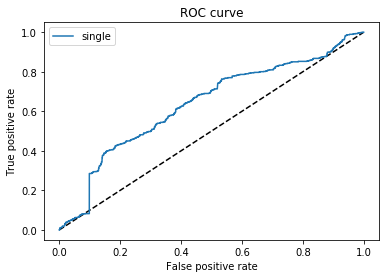

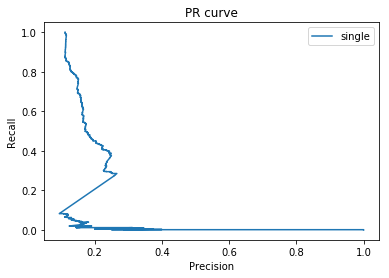

In [144]:

ypred_rbm = regr.predict( rbm.transform(Xtest))
ydata.update( {'RBM':{ 'Ytest': ypred_rbm , 'Ytrue':Ytest} } )

ROC_curve_single( Ytest ,  ypred_rbm )
import pickle 

with open( 'rbm_human.pkl' , 'wb')as rbmout:
    rbmout.write(pickle.dumps([rbm,regr]))

def rbm_pipeline(X):
    return( regr.predict(rbm.transform(X)))

In [30]:
#try a vanilla deep NN
from keras.layers import Dense, Input
from keras.models import Sequential
import os

from keras.models import load_model
modelpath = './human_profilepairs_DNN.h5'

if os.path.exists(modelpath):
    model = load_model(modelpath)
else:

    model = Sequential()
    model.add(Dense(units=100, activation='sigmoid', input_dim=Xtest.shape[1]))
    model.add(Dense(units=50, activation='sigmoid' ) )
    model.add(Dense(units=1, activation='sigmoid' ) )
model.compile(loss='binary_crossentropy', optimizer='ADAGRAD', metrics=['accuracy'])

W0427 08:00:53.113588 139951299720576 deprecation_wrapper.py:119] From /home/cactuskid13/miniconda3/envs/pyprofiler3/lib/python3.7/site-packages/keras/backend/tensorflow_backend.py:517: The name tf.placeholder is deprecated. Please use tf.compat.v1.placeholder instead.

W0427 08:00:53.130815 139951299720576 deprecation_wrapper.py:119] From /home/cactuskid13/miniconda3/envs/pyprofiler3/lib/python3.7/site-packages/keras/backend/tensorflow_backend.py:4138: The name tf.random_uniform is deprecated. Please use tf.random.uniform instead.

W0427 08:00:53.182835 139951299720576 deprecation_wrapper.py:119] From /home/cactuskid13/miniconda3/envs/pyprofiler3/lib/python3.7/site-packages/keras/backend/tensorflow_backend.py:174: The name tf.get_default_session is deprecated. Please use tf.compat.v1.get_default_session instead.

W0427 08:00:53.183521 139951299720576 deprecation_wrapper.py:119] From /home/cactuskid13/miniconda3/envs/pyprofiler3/lib/python3.7/site-packages/keras/backend/tensorflow_back

In [31]:
generator = generateXYchunk(explicit_profiles, gold_standard , posi_percent= .5 , nsamples = 50 )

model.fit_generator(itertools.cycle(generator) , steps_per_epoch = 3000 , epochs = 100)

[INFO/MainProcess] allocating a new mmap of length 4096


Epoch 1/100
3000/3000 [==============================] - 57s 19ms/step - loss: 0.5551 - acc: 0.7283
Epoch 2/100
3000/3000 [==============================] - 88s 29ms/step - loss: 0.4820 - acc: 0.7611
Epoch 3/100
3000/3000 [==============================] - 20s 7ms/step - loss: 0.4511 - acc: 0.7799
Epoch 4/100
3000/3000 [==============================] - 19s 6ms/step - loss: 0.4429 - acc: 0.7851
Epoch 5/100
3000/3000 [==============================] - 19s 6ms/step - loss: 0.4263 - acc: 0.7951
Epoch 6/100
3000/3000 [==============================] - 19s 6ms/step - loss: 0.4228 - acc: 0.7982
Epoch 7/100
3000/3000 [==============================] - 19s 6ms/step - loss: 0.4119 - acc: 0.8041
Epoch 8/100
3000/3000 [==============================] - 19s 6ms/step - loss: 0.4087 - acc: 0.8074
Epoch 9/100
3000/3000 [==============================] - 19s 6ms/step - loss: 0.4011 - acc: 0.8107
Epoch 10/100
3000/3000 [==============================] - 20s 7ms/step - loss: 0.3988 - acc: 0.8126
Epoch 1

In [ ]:
# Save the model
model.save('./human_profilepairs_DNN.h5')


In [177]:
print(profilemat.shape)

(8121, 9345)


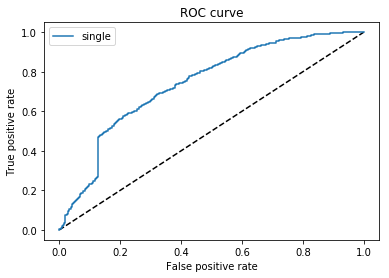

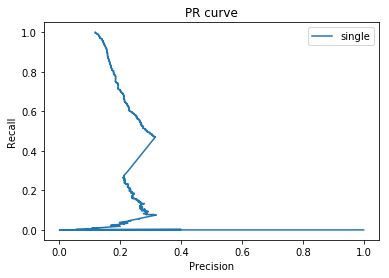

In [34]:
ypred_nn = model.predict( Xtest)
ydata.update( {'RBM':{ 'Ytest': ypred_nn , 'Ytrue':Ytest} } )
ROC_curve_single( Ytest ,  ypred_nn )


In [71]:
from scipy import linalg
from sklearn.covariance import GraphicalLassoCV , GraphicalLassoCV , EmpiricalCovariance

subprofiles = np.vstack([profilemat[fam_map[f]] for f in fams])
print(subprofiles.shape)

#use mean field
mf = GraphicalLassoCV(n_jobs = -1)
mf.fit(subprofiles.T)


(120, 9345)


/home/cactuskid13/miniconda3/envs/pyprofiler3/lib/python3.7/site-packages/sklearn/model_selection/_split.py:1978: FutureWarning: The default value of cv will change from 3 to 5 in version 0.22. Specify it explicitly to silence this warning.
  warnings.warn(CV_WARNING, FutureWarning)


GraphicalLassoCV(alphas=4, assume_centered=False, cv='warn', enet_tol=0.0001,
                 max_iter=100, mode='cd', n_jobs=-1, n_refinements=4,
                 tol=0.0001, verbose=False)

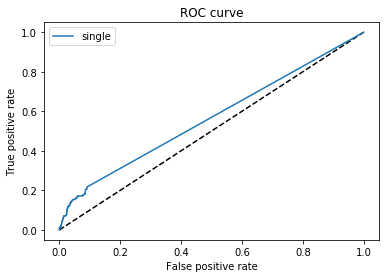

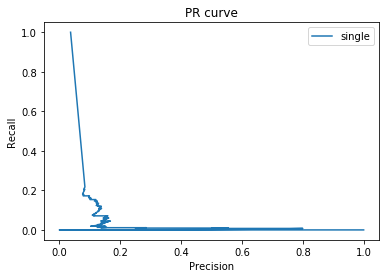

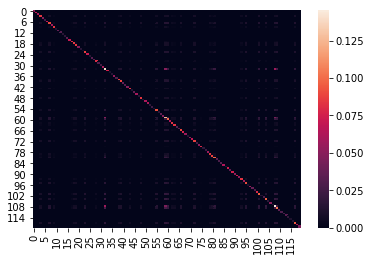

In [72]:
#sns.heatmap( mf._precision )
plt.show()
ROC_curve_single(  connectmat_binary.ravel() , mf.covariance_.ravel() )
sns.heatmap(mf.covariance_)


In [ ]:
with open( 'mf_human.pkl' , 'wb') as mfout:
    mfout.write(pickle.dumps(mf))

NN
RBM
EMP_COV
MF_DCA
PL_DCA
JACCARD


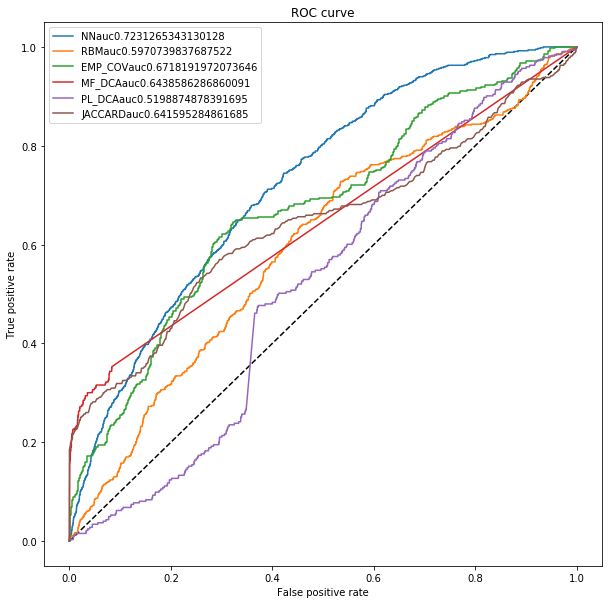

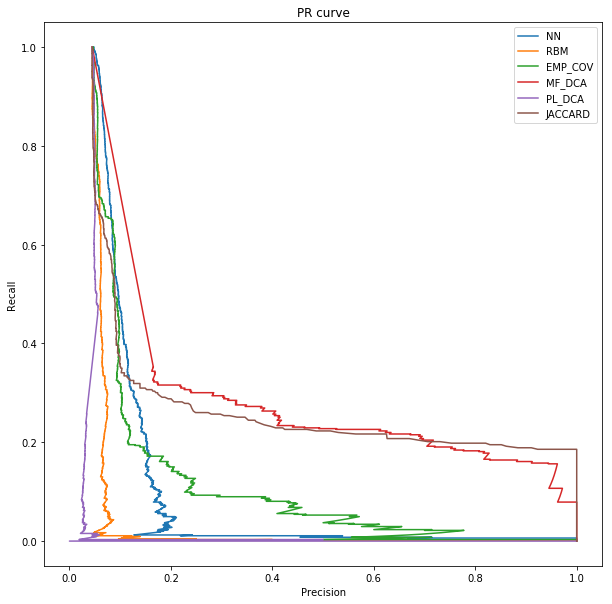

In [176]:
#use covariance

ydata = { 'NN': {'Ytrue':connectmat_binary.ravel(), 'Ypred': ymatnn.ravel() } , 'RBM':{'Ytrue':connectmat_binary.ravel() , 'Ypred': ymatrbm.ravel()} , 'EMP_COV': {'Ytrue':connectmat_binary.ravel(),'Ypred':emp.covariance_.ravel() } , 
         'MF_DCA':{'Ytrue':connectmat_binary.ravel(),'Ypred': mf.covariance_.ravel()} , 'PL_DCA':{'Ytrue':connectmat_binary.ravel(),'Ypred': predmat.ravel() } , 'JACCARD':{'Ytrue':connectmat_binary.ravel() , 'Ypred': jkern.ravel()  } }


ROC_curve(ydata)

In [52]:
                   
                        
emp = EmpiricalCovariance()
emp.fit(subprofiles.T)

EmpiricalCovariance(assume_centered=False, store_precision=True)

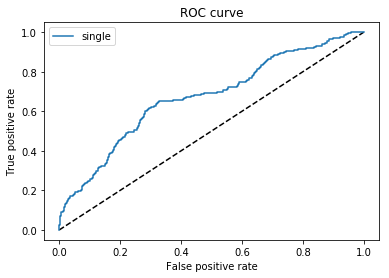

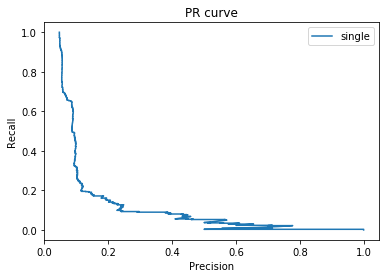

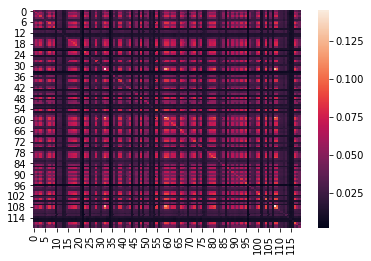

In [150]:
ROC_curve_single(  connectmat_binary.ravel(),   emp.covariance_.ravel()  )


sns.heatmap( emp.covariance_ )

In [78]:
#use DCA
import pydca
print(len(fams))
dca_profiles={}
for f in fams:
    msaprofile = p.return_profile_OTF_DCA( f )
    dca_profiles.update(msaprofile)
    print(msaprofile)



120
{411136: {'dcastr': chararray([b'A', b'A', b'P', ..., b'P', b'P', b'A'], dtype='|S1'), 'tree': Tree node '2759' (0x7f47d601824)}}
{419844: {'dcastr': chararray([b'A', b'A', b'P', ..., b'P', b'P', b'A'], dtype='|S1'), 'tree': Tree node '2759' (-0x7ffff80b82a0861c)}}
{409608: {'dcastr': chararray([b'A', b'A', b'P', ..., b'P', b'P', b'A'], dtype='|S1'), 'tree': Tree node '2759' (-0x7ffff80b82a4778c)}}
{416267: {'dcastr': chararray([b'A', b'A', b'P', ..., b'P', b'D', b'A'], dtype='|S1'), 'tree': Tree node '2759' (-0x7ffff80b82a92c70)}}
{401932: {'dcastr': chararray([b'A', b'A', b'A', ..., b'P', b'P', b'A'], dtype='|S1'), 'tree': Tree node '33154' (-0x7ffff80b82b61438)}}
{392721: {'dcastr': chararray([b'A', b'A', b'A', ..., b'P', b'P', b'A'], dtype='|S1'), 'tree': Tree node '6072' (-0x7ffff80b82b9faa8)}}
{407061: {'dcastr': chararray([b'A', b'A', b'P', ..., b'P', b'P', b'A'], dtype='|S1'), 'tree': Tree node '2759' (0x7f45081b3e1)}}
{405525: {'dcastr': chararray([b'A', b'A', b'P', ..., b

In [109]:
msadf = pd.DataFrame.from_dict( dca_profiles , orient = 'index' ) 

msablock = np.vstack( msadf.dcastr ).T

print(msablock.shape)
print(msablock)
print(msadf.shape)

#rows with no variation contain no info... filter them out
msastr = ''
for r in range( msablock.shape[0]):
    line = ''.join([ c.decode() for c in list(msablock[r,:]) ] ) + '\n'
    line = line.replace('P','U')
    line = line.replace('D','C')
    line = line.replace('L','T')
    
    if len(set(line))>2:
        msastr+='>taxaln_'+str(r)+'\n'
        msastr+= line

with open('human_dcafile.fa','w')as dcaout:
    dcaout.write(msastr)

(3115, 120)
[[b'A' b'A' b'A' ... b'A' b'A' b'A']
 [b'A' b'A' b'A' ... b'A' b'A' b'A']
 [b'A' b'A' b'A' ... b'P' b'P' b'P']
 ...
 [b'P' b'P' b'P' ... b'P' b'P' b'P']
 [b'P' b'P' b'P' ... b'P' b'P' b'P']
 [b'A' b'A' b'A' ... b'A' b'A' b'A']]
(120, 2)


In [113]:
# import pydca modules

import seaborn as sns

from pydca.plmdca import plmdca
from pydca.sequence_backmapper import sequence_backmapper
from pydca.msa_trimmer import msa_trimmer
from pydca.contact_visualizer import contact_visualizer
from pydca.dca_utilities import dca_utilities


dcafile = 'dcafile.fa'
plmdca_inst = plmdca.PlmDCA(
    dcafile,
    'rna',
    seqid = 0.01,
    lambda_h = 5.0,
    lambda_J = 5.0,
    num_threads = 30,
    max_iterations = 1000,
)

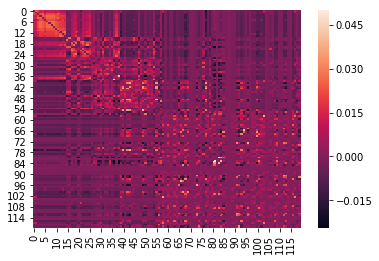

In [114]:
# compute DCA scores summarized by Frobenius norm and average product corrected
plmdca_FN_APC = plmdca_inst.compute_sorted_FN_APC()
#done, recover couplings here

predmat = np.zeros((len(fams), len(fams)))
for site_pair, score in plmdca_FN_APC:
    predmat[site_pair[0],site_pair[1]] = score
predmat+= predmat.T
sns.heatmap(predmat)

plt.show()

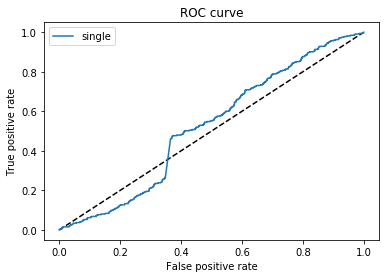

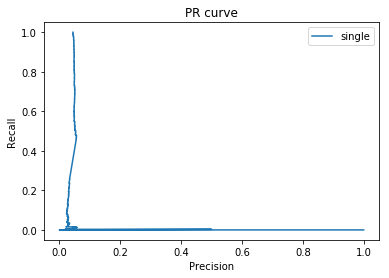

In [154]:
ydata.update({'DCA_PL':{'Ytrue': connectmat_binary.ravel() , 'Ypred':predmat.ravel() }} )
ROC_curve_single(  connectmat_binary.ravel(),   predmat.ravel()  )


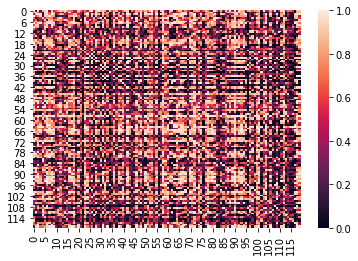

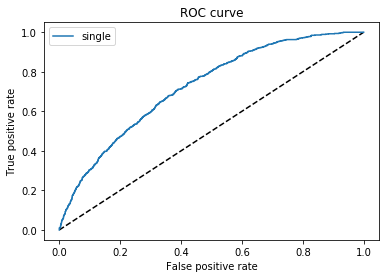

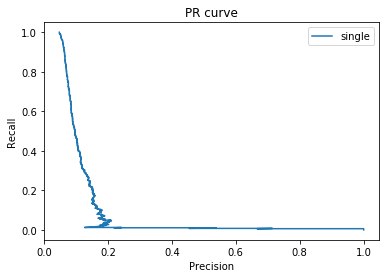

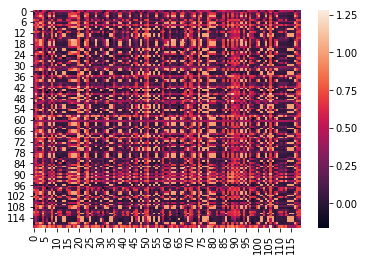

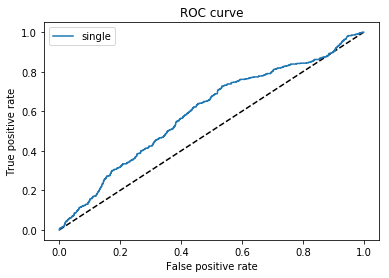

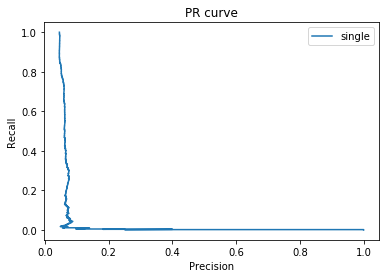

In [153]:
nfams = subprofiles.shape[0]
xtest = np.vstack([ [ np.hstack([ subprofiles[i,:], subprofiles[j,:] ]) for i in range(nfams) ] for j in range(nfams) ] )
    

ymatnn = model.predict(xtest).reshape((nfams,nfams))

sns.heatmap(ymatnn)
plt.show()
ROC_curve_single(  connectmat_binary.ravel(),   ymatnn.ravel()  )



ymatrbm = regr.predict(rbm.transform(xtest)).reshape((nfams,nfams))
sns.heatmap(ymatrbm)
plt.show()
ROC_curve_single(  connectmat_binary.ravel(),   ymatrbm.ravel()  )


In [157]:
#test the interaction detection power of just the jkern first

import multiprocessing as mp
#generate submatrices for inversion

hashes = p.pull_hashes(fams)


def yieldpairs(hashes):
    for i,h1 in enumerate(hashes):
        for j,h2 in enumerate(hashes):
            if i < j:
                yield [i,j,h1,h2]
def distance(work):
    i,j,h1,h2 = work
    return [i,j,h1.jaccard(h2)]

pool = mp.Pool()
hashes = list(hashes.values())
res = pool.map_async( distance , yieldpairs(hashes)).get()
i,j, dist = zip(*res)
jkern = np.zeros( (len(hashes),len(hashes)))
jkern[i,j]=dist
jkern += jkern.T
np.fill_diagonal(jkern, 1)

pool.close()

[INFO/ForkPoolWorker-393] child process calling self.run()
[INFO/ForkPoolWorker-394] child process calling self.run()
[INFO/ForkPoolWorker-395] child process calling self.run()
[INFO/ForkPoolWorker-396] child process calling self.run()
[INFO/ForkPoolWorker-397] child process calling self.run()
[INFO/ForkPoolWorker-398] child process calling self.run()
[INFO/ForkPoolWorker-399] child process calling self.run()
[INFO/ForkPoolWorker-400] child process calling self.run()
[INFO/ForkPoolWorker-401] child process calling self.run()
[INFO/ForkPoolWorker-402] child process calling self.run()
[INFO/ForkPoolWorker-403] child process calling self.run()
[INFO/ForkPoolWorker-404] child process calling self.run()
[INFO/ForkPoolWorker-405] child process calling self.run()
[INFO/ForkPoolWorker-406] child process calling self.run()
[INFO/ForkPoolWorker-407] child process calling self.run()
[INFO/ForkPoolWorker-408] child process calling self.run()
[INFO/ForkPoolWorker-409] child process calling self.run

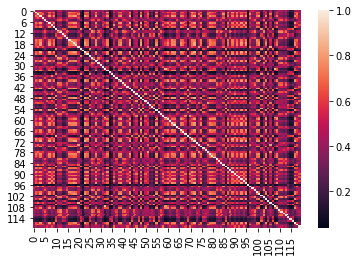

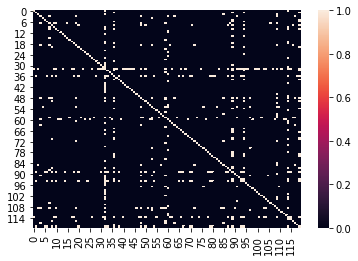

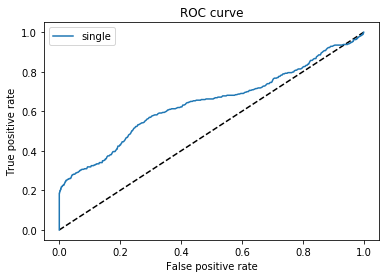

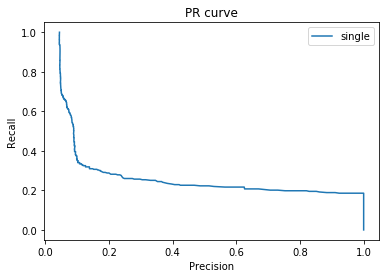

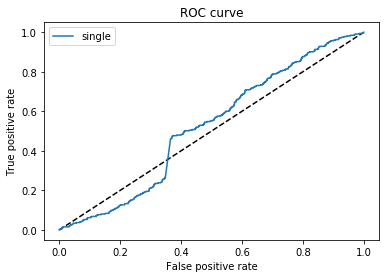

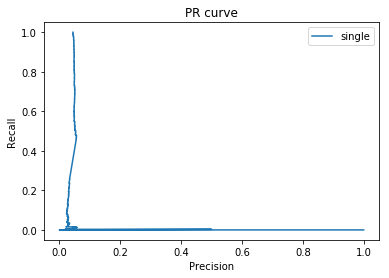

In [158]:

sns.heatmap(jkern)
plt.show()

sns.heatmap(connectmat_binary)
plt.show()



ROC_curve_single( connectmat_binary.ravel()  , jkern.ravel() )

ROC_curve_single(connectmat_binary.ravel() , predmat.ravel() )


In [ ]:
#lets compare the organisation of the complex in both as graph structures
import networkx as nx



pG = nx.from_numpy_matrix( pearsondf.to_numpy() )
jG = nx.from_numpy_matrix( jkern )
pG = nx.relabel_nodes( pG , { i:p for i,p in enumerate(pearsondf.index) })
jG = nx.relabel_nodes( jG , { i:p for i,p in enumerate(profiles.name) })
print(pG)
print(jG)
alledges={}
shared={}
topk = 20

for g in [jG, pG]:
    finalg = nx.Graph()
    for n in g.nodes():
        alledges = [ (n,l) for l in g.neighbors(n) if n != l ]
        weights = [ g[e[0]][e[1]]['weight'] for e in alledges]
        keep = np.flip(np.argsort(weights))[0:topk]
        edges = [ alledges[s] for s in list(keep) ]
        [  finalg.add_edge(e[0],e[1], weight= max(1/(i +1),g[e[0]][e[1]]['weight']) ) if finalg.has_edge(e[0],e[1]) else finalg.add_edge(e[0],e[1], weight= g[e[0]][e[1]]['weight']) for i,e in enumerate(edges)   ]
    pos = nx.spring_layout( finalg , weight='weight')
    weights = np.asarray([e[2]['weight'] for e in g.edges(data = True)])
    plt.figure( figsize = (17,17))
    cvec = [ colordict[n] if n in colordict else 'black' for n in finalg.nodes()]
    nx.draw(finalg, pos=pos, edge_color='grey', width= 2*np.log( weights ), node_size= 700, node_color = cvec ,alpha = .25 ) 
    labels=nx.draw_networkx_labels(finalg , pos = pos , font_size= 25 )
    plt.show()


In [22]:
with open( '/home/cactuskid13/mntpt/CATH/cath-names.txt') as cathin:
    cathnames  = { i:{  j : w.strip()   for j,w in enumerate(l.split('    ')) } for i,l in enumerate(cathin)  if l[0] != '#'}
cathdf = pd.DataFrame.from_dict(cathnames, orient= 'index')
mapper = dict(zip(cathdf[0], cathdf[2]))

FileNotFoundError: [Errno 2] No such file or directory: '/home/cactuskid13/mntpt/CATH/cath-names.txt'

In [ ]:
def hog_arch(fam):
    try:
        return p.db_obj.get_representative_entry_of_hog(fam)
    except:
        return None

def annotate_domain( domainlist ):
    if domainlist is not None:
        return [ mapper[ x[1].decode() ] if x[1].decode() in mapper else None for x in domainlist ]
    else:
        return None

In [ ]:
result_domains = { h : { 'rep_entry': hog_arch(h)} for h in set(hogs+ list(res.keys()) )}
print(result_domains)
result_domains = pd.DataFrame.from_dict( result_domains, orient = 'index')
result_domains['domains'] =  result_domains.rep_entry.map( lambda x : x['domains'] if x else None )
result_domains['cath'] = result_domains['domains'].map( annotate_domain) 

In [ ]:
def hog_arch(fam):
    try:
        return p.db_obj.get_representative_entry_of_hog(fam)
    except:
        return None
explicit_profiles['prots'] = explicit_profiles.index.map( hog_arch )
explicit_profiles['domains'] = explicit_profiles.prots.map( lambda x : x['domains'] if x else None )

In [ ]:
with open( '/home/cactuskid13/mntpt/CATH/cath-names.txt') as cathin:
    cathnames  = { i:{  j : w.strip()   for j,w in enumerate(l.split('    ')) } for i,l in enumerate(cathin)  if l[0] != '#'}
cathdf = pd.DataFrame.from_dict(cathnames, orient= 'index')
mapper = dict(zip(cathdf[0], cathdf[2]))